In [1]:
using Pkg
Pkg.activate(".")

  Activating project at `~/code/phasor_julia`


In [2]:
include("src/spiking.jl")
include("src/vsa.jl")

similarity_outer (generic function with 1 method)

In [3]:
using Plots

In [4]:
n_samples = 101

101

In [5]:
phase_x = zeros(Float32, 1, n_samples)

1×101 Matrix{Float32}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0

In [6]:
phase_y = range(start = -1.0, stop = 1.0, length = n_samples) |> collect;
phase_y = reshape(phase_y, 1, n_samples);

In [7]:
phase_z = bind(phase_x, phase_y)

1×101 Matrix{Float64}:
 -1.0  -0.98  -0.96  -0.94  -0.92  -0.9  …  0.9  0.92  0.94  0.96  0.98  -1.0

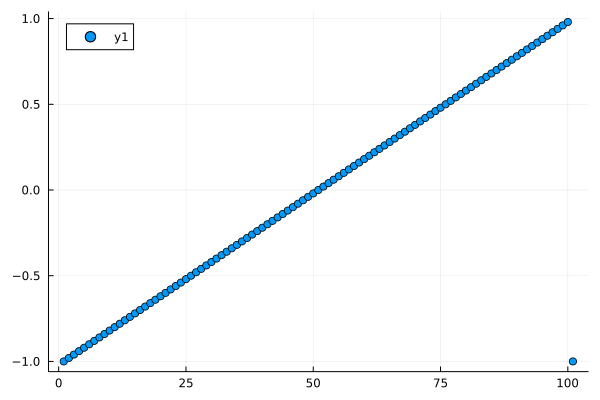

In [8]:
scatter(phase_z |> vec)

In [9]:
spk_args = default_spk_args()

Neuron parameters: Period 1.0 (s)
Current kernel duration: 0.03 (s)
Threshold: 0.02 (V)


In [10]:
st_x = phase_to_train(phase_x, spk_args)
st_y = phase_to_train(phase_y, spk_args)

Spike Train: (1, 101) with 101 spikes.

In [11]:
tspan = (0.0, 10.0)

(0.0, 10.0)

In [12]:
function neuron_constant(spk_args::SpikingArgs)
    angular_frequency = period_to_angfreq(spk_args.t_period)
    k = (spk_args.leakage + 1im * angular_frequency)
    return k
end

function period_to_angfreq(t_period::Real)
    angular_frequency = 2 * pi / t_period
    return angular_frequency
end

period_to_angfreq (generic function with 1 method)

In [13]:
using OrdinaryDiffEq

In [14]:
function bind(x::SpikeTrain, y::SpikeTrain, tspan::Tuple{<:Real, <:Real}, spk_args::SpikingArgs)
    #set up functions to define the neuron's differential equations
    k = neuron_constant(spk_args)
    #get the number of batches & output neurons
    output_shape = x.shape

    #integrate current through the first compartment that will flow through into the second
    #set up the first compartment
    u0 = zeros(ComplexF32, output_shape)
    dzdt_x(u, p, t) = k .* u + spike_current(x, t, spk_args)
    #solve the ODE for the first compartment over the given time span
    prob_x = ODEProblem(dzdt_x, u0, tspan)
    sol_x = solve(prob_x, Heun(), adaptive=false, dt=spk_args.dt)
    return sol_x
    u_x = Array(sol_x)

    #set up the second compartment
    #current will flow into the second compartment enabled by the second input and flow backards in time
    dzdt_y(u, p, t) = -k .* u + u_x * spike_current(y, t, spk_args)
    #solve the second compartment
    prob_y = ODEProblem(dzdt_y, u0, tspan)
    sol_y = solve(prob_y, Heun(), adaptive=false, dt=spk_args.dt)
    indices, times = find_spikes_rf(sol_y, spk_args)
    #construct the spike train and call for the next layer
    train = SpikeTrain(indices, times, output_shape, x.offset + spk_args.t_period / 4.0)
    next_call = SpikingCall(train, spk_args, tspan)
    return next_call

end

bind (generic function with 3 methods)

In [16]:
st_z = bind(st_x, st_y, tspan, spk_args)

retcode: Success
Interpolation: 3rd order Hermite
t: 1001-element Vector{Float64}:
  0.0
  0.01
  0.02
  0.03
  0.04
  0.05
  0.060000000000000005
  0.07
  0.08
  0.09
  ⋮
  9.919999999999833
  9.929999999999833
  9.939999999999833
  9.949999999999832
  9.959999999999832
  9.969999999999832
  9.979999999999832
  9.989999999999831
 10.0
u: 1001-element Vector{Matrix{ComplexF32}}:
 [0.0f0 + 0.0f0im 0.0f0 + 0.0f0im … 0.0f0 + 0.0f0im 0.0f0 + 0.0f0im]
 [0.0f0 + 0.0f0im 0.0f0 + 0.0f0im … 0.0f0 + 0.0f0im 0.0f0 + 0.0f0im]
 [0.0f0 + 0.0f0im 0.0f0 + 0.0f0im … 0.0f0 + 0.0f0im 0.0f0 + 0.0f0im]
 [0.0f0 + 0.0f0im 0.0f0 + 0.0f0im … 0.0f0 + 0.0f0im 0.0f0 + 0.0f0im]
 [0.0f0 + 0.0f0im 0.0f0 + 0.0f0im … 0.0f0 + 0.0f0im 0.0f0 + 0.0f0im]
 [0.0f0 + 0.0f0im 0.0f0 + 0.0f0im … 0.0f0 + 0.0f0im 0.0f0 + 0.0f0im]
 [0.0f0 + 0.0f0im 0.0f0 + 0.0f0im … 0.0f0 + 0.0f0im 0.0f0 + 0.0f0im]
 [0.0f0 + 0.0f0im 0.0f0 + 0.0f0im … 0.0f0 + 0.0f0im 0.0f0 + 0.0f0im]
 [0.0f0 + 0.0f0im 0.0f0 + 0.0f0im … 0.0f0 + 0.0f0im 0.0f0 + 0.0f0i